In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import datetime as dt
from datetime import timedelta

In [3]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
#Create an Engine with Sqlite
engine = create_engine("sqlite:///hawaiicopy.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

## Data Exploration / Tables and columns

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Alternative Way using the inspector
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Inspector to print the column names and types
#Measurement 
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Inspector to print the column names and types
#Station 
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
## Refernce each table and store in variable

Measurement = Base.classes.measurement

Station = Base.classes.station

## Session Creation to perform analysis

In [11]:
session = Session(engine)

## Exploratory Climate Analysis
- Precipitation Analysis
1 -  Design a query to retrieve the last 12 months of precipitation data.
2 - Select only the date and prcp values.
3 - Load the query results into a Pandas DataFrame and set the index to the date column.
4 - Plot the results using the DataFrame plot method.

In [12]:
# Calculate the date 1 year ago from the last data point in the database

# Step 1 - Find Max Date
max_date = engine.execute("SELECT max(date) FROM measurement").fetchall()
max_date = max_date[0][0]
max_date

'2017-08-23'

In [13]:
# Step 2 find the year old date

today = dt.date.today()
max_dateformat = today.replace(year=int(max_date[:4]),month=int(max_date[5:7]),day=int(max_date[8:]))
Last_date_year = max_dateformat - dt.timedelta(days=365)    
Start_Date = Last_date_year.strftime("%Y-%m-%d")
print(Start_Date)



2016-08-23


In [14]:
# a query to retrieve the data and precipitation scores
prec_dates = session.query(Measurement.date, Measurement.prcp)\
             .filter(Measurement.date >= Start_Date)\
             .filter(Measurement.date <= max_date)\
             .order_by(Measurement.date.desc())\
             .all()

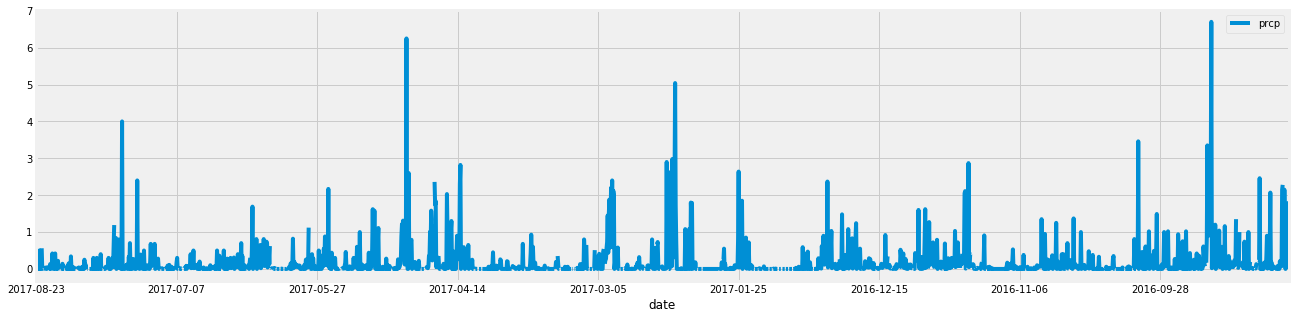

In [15]:
# Converting to DF and plotting

df = pd.DataFrame(prec_dates)
df.set_index('date', inplace=True)
df.plot(figsize=(20,5))
plt.show()

In [16]:
# summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Stations Analysis

In [17]:
# A query to show how many stations are available in this dataset?
num_stations = session.query(Station.name).count()
print(f"There are {num_stations} stations.")

There are 9 stations.


In [18]:
# most active stations? 
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

i = 1
for x in most_active_stations:
        print(f"Station Rank {i} is:")
        print(x[0])
        i += 1


Station Rank 1 is:
USC00519281
Station Rank 2 is:
USC00519397
Station Rank 3 is:
USC00513117
Station Rank 4 is:
USC00519523
Station Rank 5 is:
USC00516128
Station Rank 6 is:
USC00514830
Station Rank 7 is:
USC00511918
Station Rank 8 is:
USC00517948
Station Rank 9 is:
USC00518838


In [19]:
#the lowest temperature recorded, highest temperature recorded, and average temperature most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
            .filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
most_active = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).count()
most_active

9

In [21]:
highest_observations = session.query(Measurement.station,func.count(Measurement.station))\
                      .group_by(Measurement.station)\
                      .order_by(func.count(Measurement.station).desc()).first()

In [35]:
#the last 12 months of temperature observation data for this station 
last_twelve = session.query(Measurement.date, Measurement.tobs)\
.filter(Measurement.station == highest_observations[0])\
.filter(Measurement.date >= Start_Date)\
.filter(Measurement.date<=max_date)\
.order_by(Measurement.date.desc()).all()

In [40]:
df = pd.DataFrame(last_twelve, columns=["Date", "Temp"])


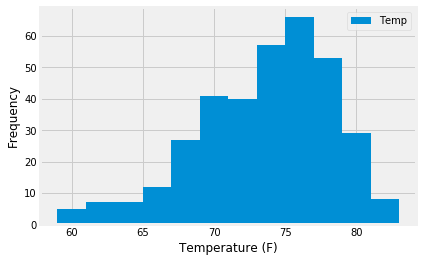

In [49]:
df.plot.hist(by="Temp",bins=12,label="Temp")
plt.ylim=(0,80)
plt.xlabel("Temperature (F)")
plt.legend=()
plt.show()